# CIC-IDS-2018 Dataset Analysis

## Imports

In [43]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

# For oversampling
from imblearn.over_sampling import SMOTE

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical analysis
import scipy

# For timing
import time

## Acquire Data

In [44]:
# Read the CSV file into a dataframe
combined_df = pd.read_csv("/Users/lucky/GitHub/DDoS-Hybrid-Detection-System/datasets/cic_ids_2018/cleaned_combined.csv")

## Data Preprocessing

In [45]:
# Get general information about the dataframe
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2978160 entries, 0 to 2978159
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Timestamp          object 
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    int64  
 7   TotLen Bwd Pkts    int64  
 8   Fwd Pkt Len Max    int64  
 9   Fwd Pkt Len Min    int64  
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    int64  
 13  Bwd Pkt Len Min    int64  
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       int64  
 21  Flow IAT Min       int64  
 22  Fwd IAT Tot        int64  
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        float64
 25  Fwd IAT Max       

In [46]:
# Maintain a copy of the original dataframe
original_df = combined_df.copy()

# Remove duplicates
combined_df.drop_duplicates(inplace=True)
# Replace infinity with NaN
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove columns with all NaN values
combined_df.dropna(axis=1, how='all', inplace=True)
# Remove rows with any NaN values
combined_df.dropna(inplace=True)
# Acquire column names that contain object data types
object_cols = combined_df.select_dtypes(include=['object']).columns

In [47]:
combined_df.drop('Timestamp', axis=1, inplace=True)

In [48]:
# Show updated information about the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2970138 entries, 0 to 2978159
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int64  
 4   Tot Bwd Pkts       int64  
 5   TotLen Fwd Pkts    int64  
 6   TotLen Bwd Pkts    int64  
 7   Fwd Pkt Len Max    int64  
 8   Fwd Pkt Len Min    int64  
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    int64  
 12  Bwd Pkt Len Min    int64  
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       int64  
 20  Flow IAT Min       int64  
 21  Fwd IAT Tot        int64  
 22  Fwd IAT Mean       float64
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        int64  
 25  Fwd IAT Min        int6

## Train/Test Split (80/20)

In [49]:
combined_df.shape

(2970138, 79)

In [50]:
X = combined_df.drop(' Label', axis=1)
y = combined_df[' Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Helper function to add bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

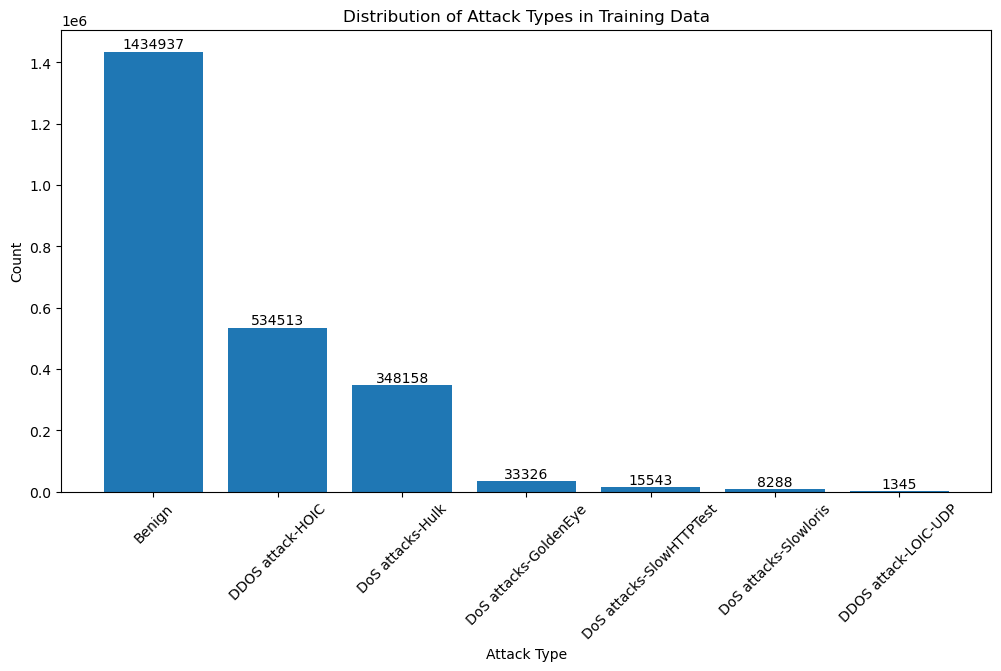

In [52]:
# Check the distribution of the labels in training data
train_attack_counts = y_train.value_counts()
plt.figure(figsize=(12,6))
bars = plt.bar(train_attack_counts.index, train_attack_counts.values)
add_bar_labels(bars)
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types in Training Data")
plt.xticks(rotation=45)
plt.show()

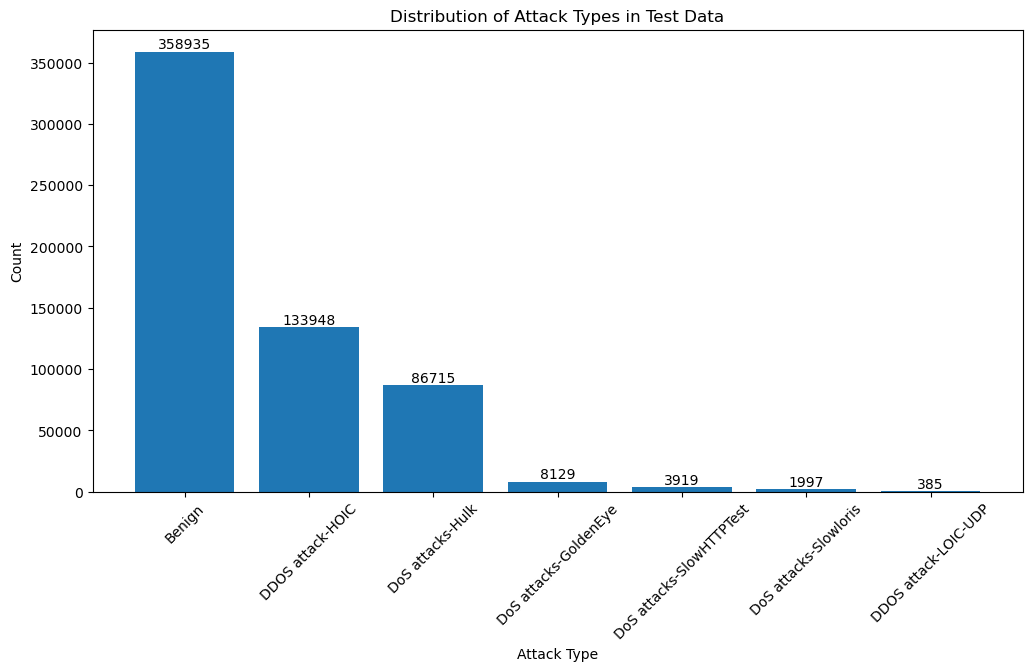

In [53]:
# Check the distribution of the labels in test data
test_attack_counts = y_test.value_counts()
plt.figure(figsize=(12,6))
bars = plt.bar(test_attack_counts.index, test_attack_counts.values)
add_bar_labels(bars)
plt.xlabel("Attack Type")
plt.ylabel("Count") 
plt.title("Distribution of Attack Types in Test Data")
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [37]:
# Mutual information feature selection
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Init Fwd Win Byts    0.946805
Fwd Header Len       0.763761
Fwd Seg Size Avg     0.594059
Fwd Pkt Len Mean     0.593868
Fwd IAT Mean         0.586121
                       ...   
Fwd Byts/b Avg       0.000097
Fwd Blk Rate Avg     0.000036
Bwd PSH Flags        0.000000
Fwd URG Flags        0.000000
Bwd Pkts/b Avg       0.000000
Length: 78, dtype: float64

<Axes: >

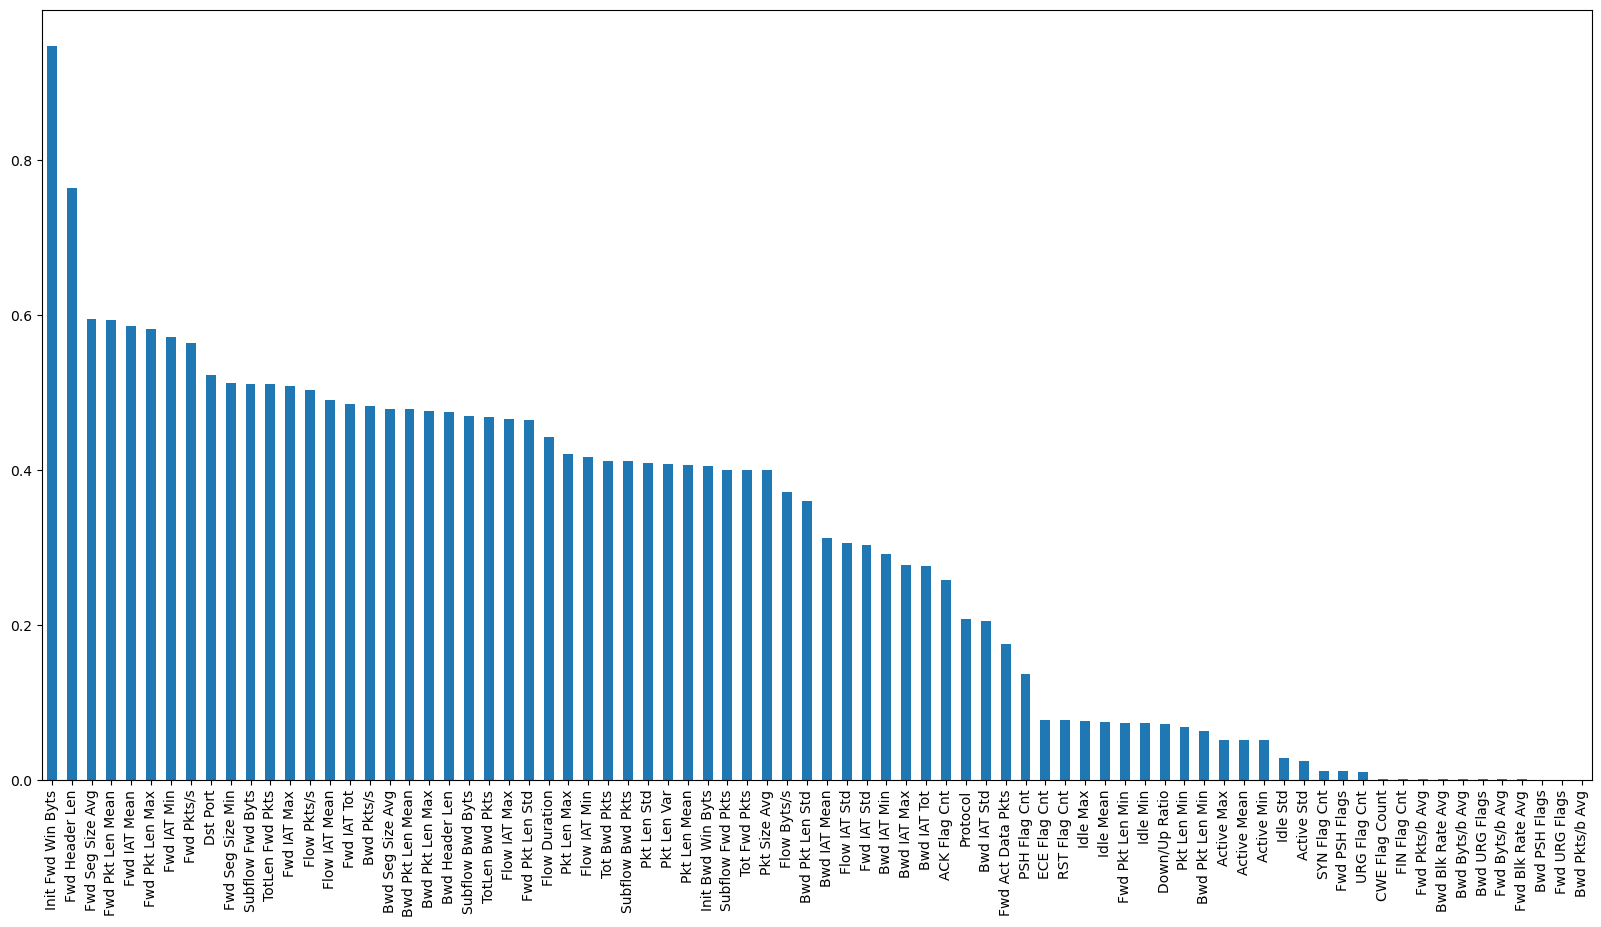

In [38]:
# Display in bar chart
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,10))

In [54]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=20)
top_20_features.fit(X_train, y_train)
X_train.columns[top_20_features.get_support()]

KeyboardInterrupt: 

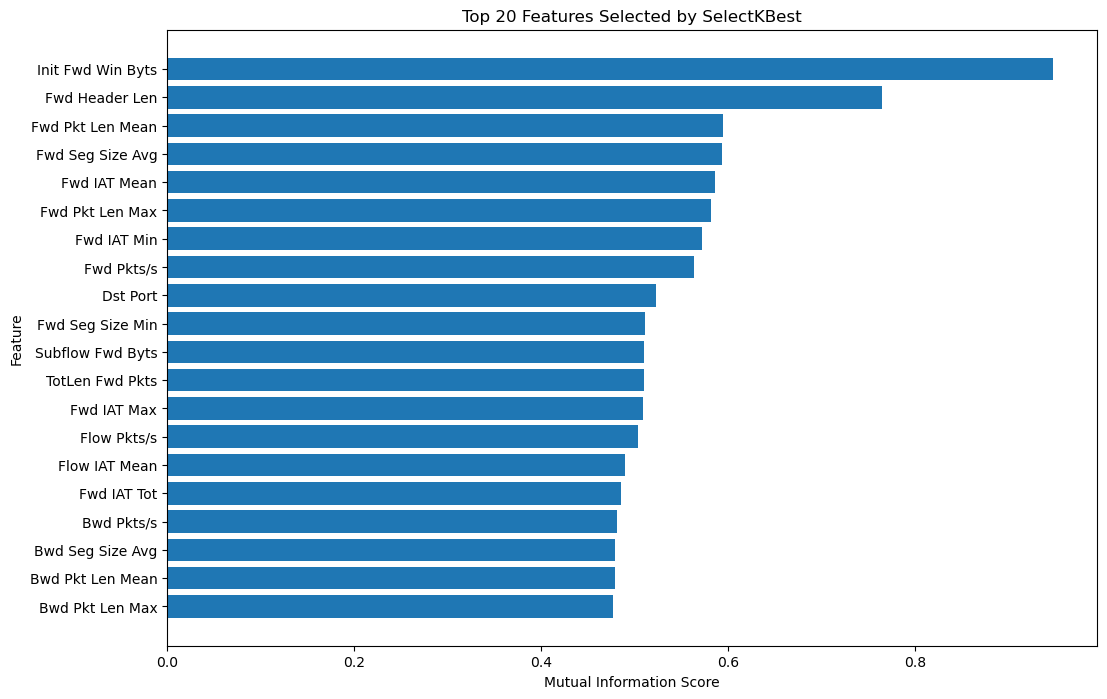

In [42]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [55]:
top_20_features = ['Dst Port', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min',
       'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Init Fwd Win Byts',
       'Fwd Seg Size Min']

X_train=X_train[top_20_features]
X_test=X_test[top_20_features]

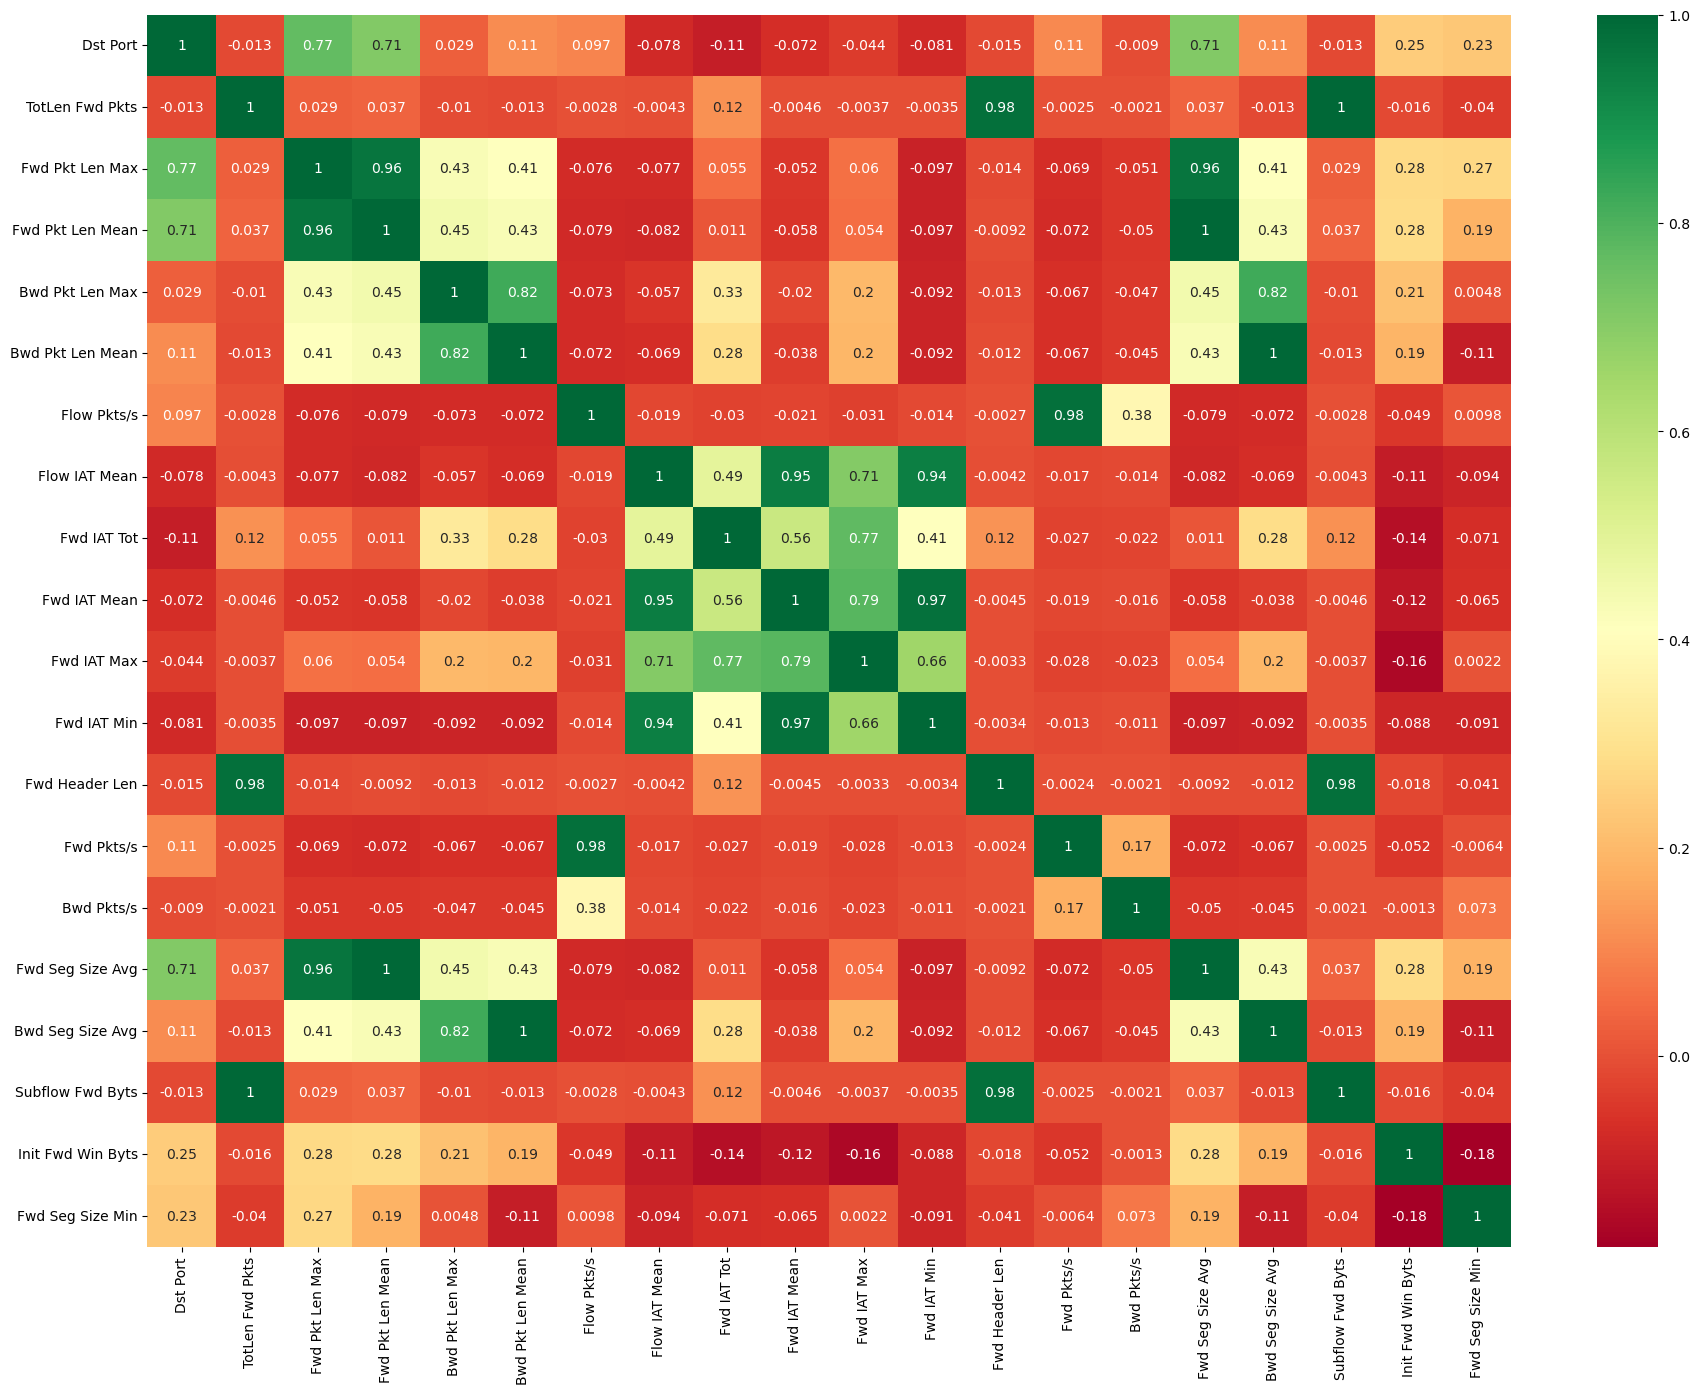

In [17]:
plt.figure(figsize=(22,16))
top_20_heatmap = sns.heatmap(X_train.corr(), annot=True, cmap='RdYlGn')

## Encoding and Scaling

In [56]:
# Scale and Encode Data
scaler = StandardScaler()
le = LabelEncoder()

# Fit and transform the training data
X_train = scaler.fit_transform(X_train)
y_train = le.fit_transform(y_train)
# Transform the testing data
X_test = scaler.transform(X_test)
y_test = le.transform(y_test)

## Train Models

In [19]:
# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.9999949497330092
Precision: 0.9999981374846226
Recall: 0.9999809617193446
F1 Score: 0.9999895490612081
Confusion Matrix:
[[358934      1      0      0      0      0      0]
 [     1 133947      0      0      0      0      0]
 [     0      0    385      0      0      0      0]
 [     1      0      0   8128      0      0      0]
 [     0      0      0      0  86715      0      0]
 [     0      0      0      0      0   3919      0]
 [     0      0      0      0      0      0   1997]]
Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    358935
        DDOS attack-HOIC       1.00      1.00      1.00    133948
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       385
   DoS attacks-GoldenEye       1.00      1.00      1.00      8129
        DoS attacks-Hulk       1.00      1.00      1.00     86715
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      3919


## Confusion Matrix

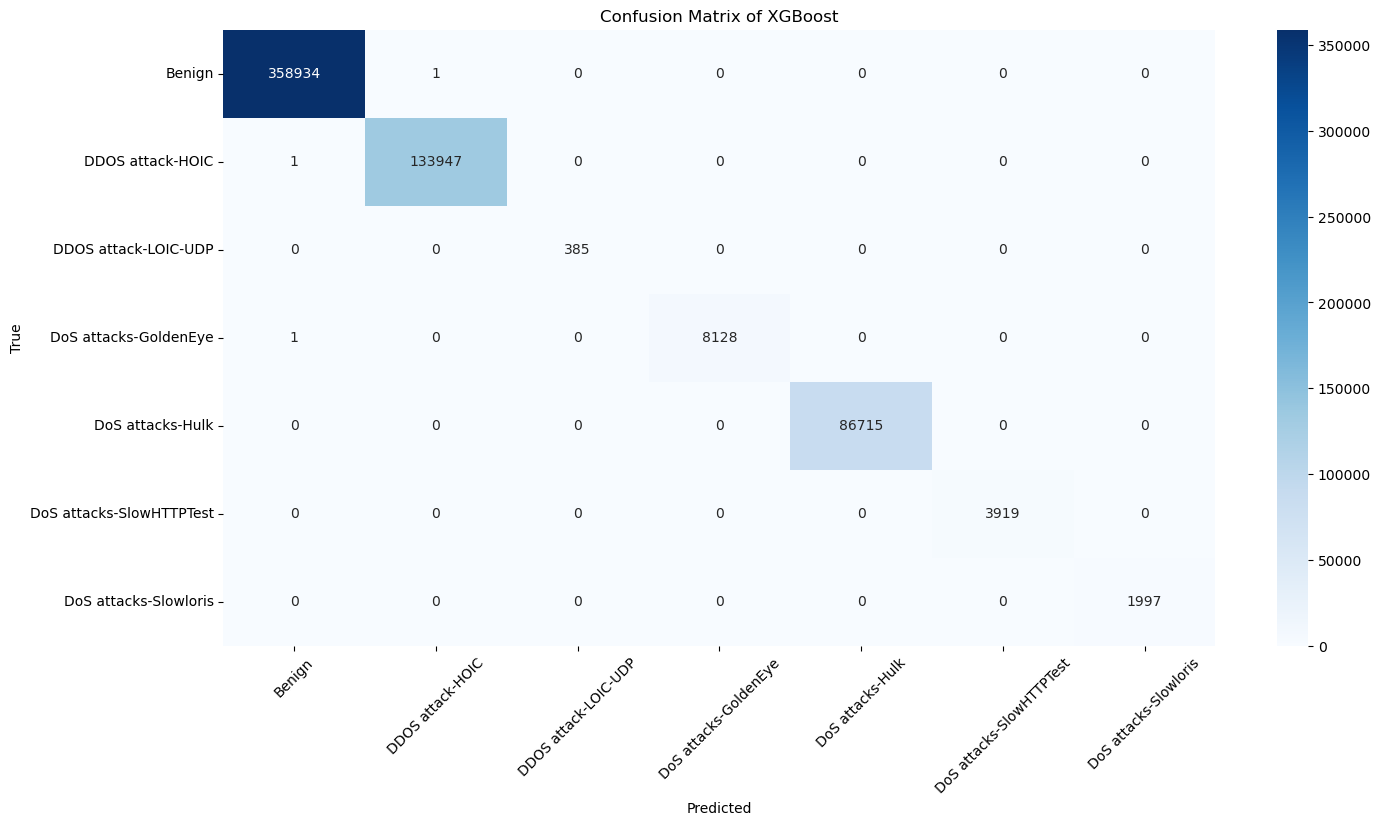

In [24]:
# Plot confusion matrix
plt.figure(figsize=(16, 8))
sns.heatmap(results['XGBoost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.title('Confusion Matrix of XGBoost')
plt.show()

In [22]:
# Save the combined dataframe to a new CSV file if needed
combined_df.to_csv('/Users/lucky/GitHub/DDoS-Hybrid-Detection-System/datasets/combined_cic_ids_2019.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70427637 entries, 0 to 70427636
Data columns (total 88 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Unnamed: 0                    int64  
 1   Flow ID                       object 
 2    Source IP                    object 
 3    Source Port                  int64  
 4    Destination IP               object 
 5    Destination Port             int64  
 6    Protocol                     int64  
 7    Timestamp                    object 
 8    Flow Duration                int64  
 9    Total Fwd Packets            int64  
 10   Total Backward Packets       int64  
 11  Total Length of Fwd Packets   float64
 12   Total Length of Bwd Packets  float64
 13   Fwd Packet Length Max        float64
 14   Fwd Packet Length Min        float64
 15   Fwd Packet Length Mean       float64
 16   Fwd Packet Length Std        float64
 17  Bwd Packet Length Max         float64
 18   Bwd Packet Length M

## Autoencoder-XGB

In [60]:
import tensorflow as tf

input_dim = X_train.shape[1]

# Reshape data for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(1, 3, activation='tanh', padding='same')
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,169 (20.19 KB)

 Trainable params: 5,169 (20.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         1,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336 (16.94 KB)

 Trainable params: 4,336 (16.94 KB)

 Non-trainable params: 0 (0.00 B)

None


### Training

In [63]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    X_train_reshaped, 
    X_train_reshaped, 
    epochs=100, 
    batch_size=128, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time


Epoch 1/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5563 - val_loss: 0.5127
Epoch 2/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5235 - val_loss: 0.5126
Epoch 3/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5184 - val_loss: 0.5126
Epoch 4/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5158 - val_loss: 0.5127
Epoch 5/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5338 - val_loss: 0.5126
Epoch 6/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5261 - val_loss: 0.5126
Epoch 7/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5346 - val_loss: 0.5127
Epoch 8/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.5224 - val_loss: 0.5126
Epoch 9/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5311 - val_loss: 0.5126
Epoch 10/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5298 - val_loss: 0.5126
Epoch 11/100
14851/14851 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5267 - val

In [64]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(X_train_reshaped)
encoded_test = encoder.predict(X_test_reshaped)

74254/74254 ━━━━━━━━━━━━━━━━━━━━ 28s 381us/step
18564/18564 ━━━━━━━━━━━━━━━━━━━━ 7s 355us/step


In [65]:
# Flatten the encoded data for combining
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

# Combine original and encoded features
combined_train = np.concatenate((X_train, encoded_train_flat), axis=1)
combined_test = np.concatenate((X_test, encoded_test_flat), axis=1)

In [72]:
encoded_test_flat.shape

(594028, 80)

In [75]:
# Create the XGBoost classifier
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
eval_set = [(encoded_train_flat, y_train), (encoded_test_flat, y_test)]
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Decode labels for evaluation
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

# Store the results
results = {}
results["xgboost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- {"xgboost"} ---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')

--- xgboost ---
Accuracy: 0.9999680149757251
Precision: 0.9995984761461968
Recall: 0.9996759697507637
F1 Score: 0.999637199835948
Confusion Matrix:
[[358925      0      0      4      2      3      1]
 [     0 133948      0      0      0      0      0]
 [     0      0    385      0      0      0      0]
 [     3      0      0   8123      1      0      2]
 [     0      0      0      0  86715      0      0]
 [     0      0      0      0      0   3919      0]
 [     3      0      0      0      0      0   1994]]
Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    358935
        DDOS attack-HOIC       1.00      1.00      1.00    133948
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       385
   DoS attacks-GoldenEye       1.00      1.00      1.00      8129
        DoS attacks-Hulk       1.00      1.00      1.00     86715
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      3919
 

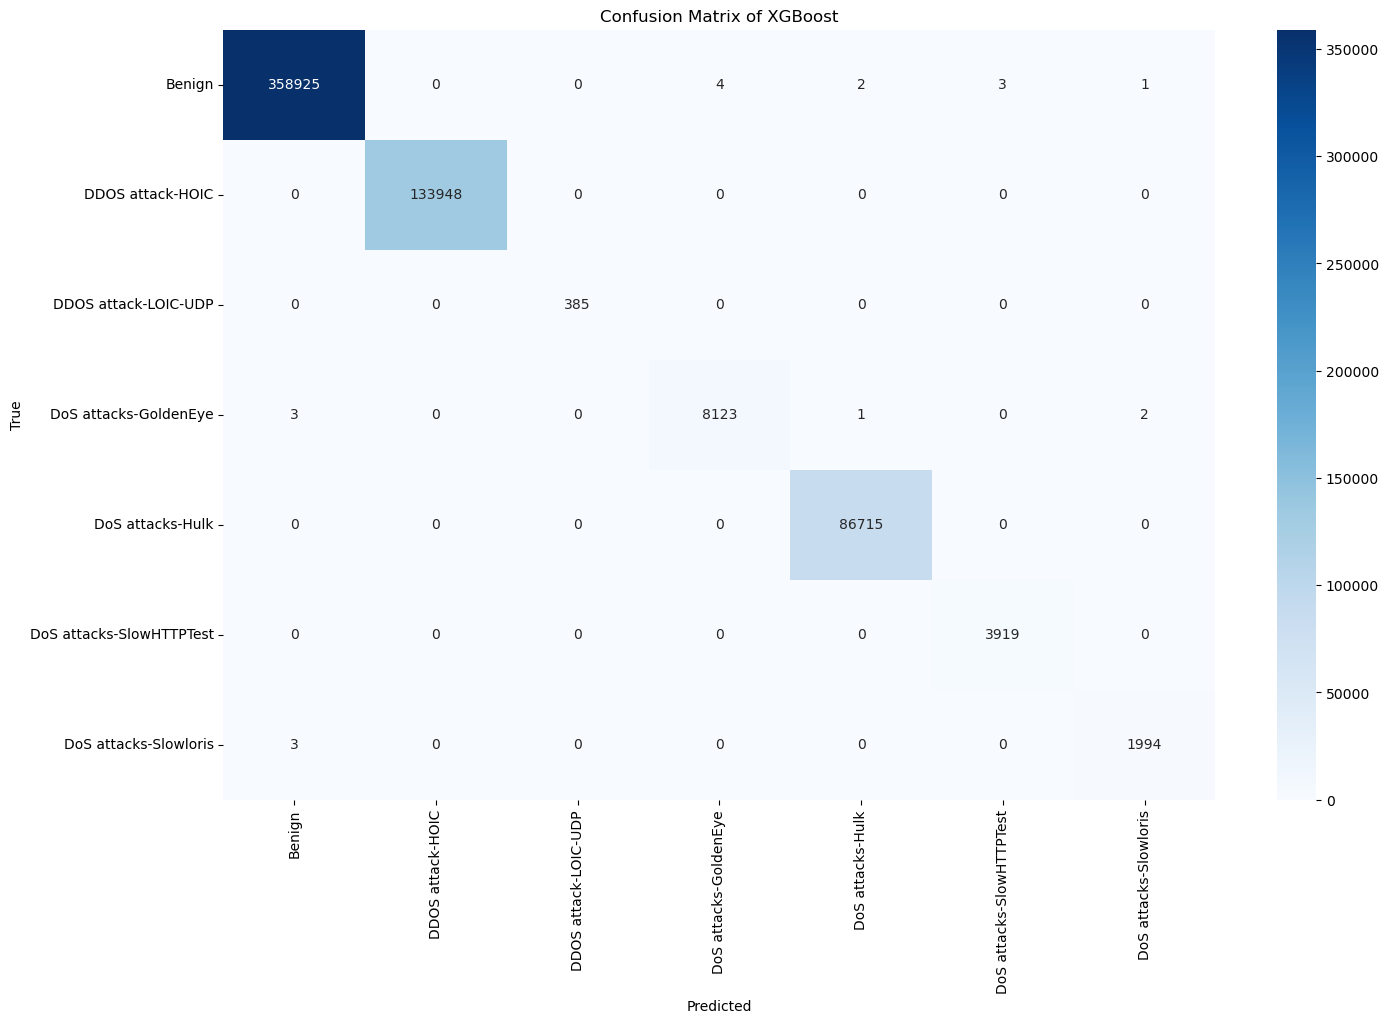

In [76]:
# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(results['xgboost']['conf_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of XGBoost')
plt.show()